In [58]:
#import necessary frameworks.
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split

In [21]:
# Load Electronics ratings data.
# Add column names.
e_commerce_data = pd.read_csv('ratings_Electronics.csv')
e_commerce_data.columns = ['userId','productId','userRating','timestamp']

In [22]:
# Let's see how the data is present.
e_commerce_data.head()

,userId,productId,userRating,timestamp
0,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
1,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
2,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
3,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200
4,A1QGNMC6O1VW39,0511189877,5.0,1397433600


In [23]:
# Let's check shape of the data
print(f"Numeber of rows:{e_commerce_data.shape[0]} and number of cols:{e_commerce_data.shape[1]}")

Numeber of rows:7824481 and number of cols:4


In [24]:
e_commerce_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824481 entries, 0 to 7824480
Data columns (total 4 columns):
userId        object
productId     object
userRating    float64
timestamp     int64
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


In [25]:
# Let's check any NaN value present in data.
e_commerce_data.isna().any()

userId        False
productId     False
userRating    False
timestamp     False
dtype: bool

In [87]:
e_commerce_data.userRating.describe().T

count    7.824481e+06
mean     4.012337e+00
std      1.380910e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: userRating, dtype: float64

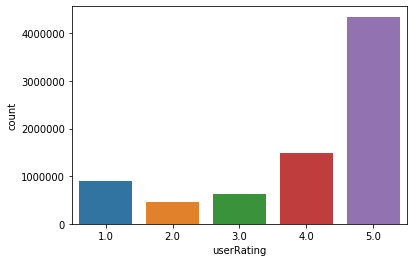

In [45]:
# Let's check distribution of userRatings
sns.countplot(e_commerce_data.userRating)

In [129]:
e_commerce_data.groupby('userId')['userRating'].count().sort_values(ascending=False)[0:10]

userId
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
A1ODOGXEYECQQ8    380
A36K2N527TXXJN    314
A2AY4YUOX2N1BQ    311
AWPODHOB4GFWL     308
A25C2M3QF9G7OQ    296
Name: userRating, dtype: int64

In [104]:
user_counts = e_commerce_data['userId'].value_counts()

In [107]:
len(user_counts[user_counts<=290])

4201684

In [108]:
new_e_commerce_data = e_commerce_data[e_commerce_data['userId'].isin(user_counts[user_counts>=290].index)]

In [109]:
new_e_commerce_data.shape

(4553, 4)

In [110]:
train_data,test_data = train_test_split(new_e_commerce_data,test_size=0.2,random_state=42)

In [111]:
train_data.shape, test_data.shape

((3642, 4), (911, 4))

In [112]:
train_data.head()

,userId,productId,userRating,timestamp
7311394,A22CW0ZHY3NJH8,B00CSFCYFY,4.0,1374883200
7064067,A22CW0ZHY3NJH8,B00BB6LTI4,5.0,1362355200
5476229,A22CW0ZHY3NJH8,B006T9B6R2,4.0,1334534400
6722206,ARBKYIVNYWK3C,B009SYZ8OC,5.0,1365120000
2616161,A3OXHLG6DIBRW8,B002HWRJY4,5.0,1254873600


# Popularity based Recommender system

In [113]:
trained_data_df = train_data.groupby('productId').agg({'userId':'count'}).reset_index()
trained_data_df.rename(columns={'userId':'userID_count'},inplace=True)

In [114]:
trained_data_df.head()

,productId,userID_count
0,1400532655,1
1,9800359788,1
2,9981719005,1
3,B000001OMI,1
4,B00000J05A,1


In [121]:
trained_data_sort = trained_data_df.sort_values(['userID_count','productId'],ascending=[0,1])

In [122]:
trained_data_sort['rank'] = trained_data_sort['userID_count'].rank(ascending=False,method='first')

In [123]:
trained_data_sort.head(5)

,productId,userID_count,rank
2152,B0053R0WWG,6,1.0
2395,B0079UAT0A,6,2.0
2853,B00DTZYHX4,6,3.0
2423,B007OY5V68,5,4.0
2809,B00D5EO27U,5,5.0
